# core

> Core functionality for loading layers and preparing them.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

/Users/alice/miniforge3/envs/muir-dev/lib/python3.10/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import pandas as pd
import geopandas as gpd

In [ ]:
from muir.visualization import *
from muir.raster import *
from muir import SKIP_SYMBOL

## Demo-Specific Utils

In [ ]:
#| export
from importlib.resources import files

def get_demo_path(filename):
    return files("muir.demo").joinpath(filename)

In [ ]:
#| hide
get_demo_path("dem.tif")

Path('/Volumes/creek/muir/muir/demo/dem.tif')

## Config

In [ ]:
#| export
import yaml
import os

def load_config(config_path, dlt=[]):
    def _update_paths(d, base_path):
        if isinstance(d, dict):
            for k, v in d.items():
                if isinstance(v, (dict, list)):
                    _update_paths(v, base_path)
                elif isinstance(k, str) and "path" in k and k != "base_data_path" and isinstance(v, str):
                    if not os.path.isabs(v):
                        d[k] = os.path.join(base_path, v)
        elif isinstance(d, list):
            for item in d:
                _update_paths(item, base_path)
    with open(config_path) as f:
        config = yaml.safe_load(f)

    # update raster and vector paths to absolute paths
    if "base_data_path" in config and config["base_data_path"] is not None:
        # demo only
        if config["base_data_path"] == "[DEMO]":
            config["base_data_path"] = get_demo_path("")
            _update_paths(config, config["base_data_path"])

    # remove keys
    for key in dlt:
        if key in config:
            del config[key]
                    
    return config

We can specify the markdown in whatever format we would like, but recommended to use something like this:
```yaml
project_crs: "EPSG:5880"
base_data_path: "[DEMO]"   
buffer_factor: 2
rasters:
  - name: "lulc"
    raw_path: "lulc/raw/mapbiomas-30m-2023-bbox.tif"
    out_path: "lulc/mapbiomas-30m-2023-5880.tif"
    setnodata: 255
  ...
vectors:
  - name: "aoi"
    raw_path: "area_of_interest/raw/area_of_interest_subwatershed.shp"
    out_path: "area_of_interest/area_of_interest_5880.shp"
  ...
```

For example:

In [ ]:
config_path = get_demo_path("configs/preprocessing/preprocess-demo.yaml")
conf = load_config(config_path)
conf["rasters"]

{'lulc': {'raw_path': '/Volumes/creek/muir/muir/demo/lulc/raw/mapbiomas-30m-2023-bbox.tif',
  'out_path': '/Volumes/creek/muir/muir/demo/lulc/mapbiomas-30m-2023-5880.tif',
  'setnodata': 255,
  'resampling': 'nearest'},
 'dem': {'raw_path': '/Volumes/creek/muir/muir/demo/dem/raw/srtm-v3-1s-2025-dem-bbox.tif',
  'out_path': '/Volumes/creek/muir/muir/demo/dem/srtm-v3-1s-2025-dem-5880.tif',
  'setnodata': None,
  'resampling': 'bilinear'},
 'soil_erodibility': {'raw_path': '/Volumes/creek/muir/muir/demo/soil_erodibility/raw/K_factor_EPIC_bbox.tif',
  'out_path': '/Volumes/creek/muir/muir/demo/soil_erodibility/K-factor-EPIC-5880.tif',
  'setnodata': None,
  'resampling': 'nearest'}}

## Prepare Layers

In [ ]:
#| export

import tempfile
import os

def run_steps(start_path, end_path, steps):
    """
    Chain a sequence of processing steps, handling temp files for intermediates.
    Each step is a tuple: (func, kwargs_dict)
    - func: function(input_path, output_path, **kwargs)
    - kwargs_dict: dict of additional keyword arguments for the function
    """
    temp_paths = []
    try:
        in_path = start_path
        for i, (func, kwargs) in enumerate(steps):
            # Last step writes to end_path, others to temp files
            if i == len(steps) - 1:
                out_path = end_path
            else:
                tmp = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
                out_path = tmp.name
                tmp.close()
                temp_paths.append(out_path)
            status = func(input_path=in_path, output_path=out_path, **kwargs)
            if status != SKIP_SYMBOL: # function carried out
                in_path = out_path
    finally:
        for p in temp_paths:
            if os.path.exists(p):
                os.remove(p)


In [ ]:
#| export
def str_to_resampling(resampling_str):
    """
    Convert a string to a rasterio.enums.Resampling enum value.
    Example: "nearest" -> Resampling.nearest
    """
    try:
        return Resampling[resampling_str.lower()]
    except KeyError:
        raise ValueError(f"Unknown resampling method: {resampling_str}")

In [ ]:
#| export
from pathlib import Path
def pathstem(input_path):
    return Path(input_path).stem
def pathname(input_path):
    return Path(input_path).name

First, let's reproject the AOI to the correct projection.

In [ ]:
aoi_raw = gpd.read_file(conf["vectors"]["aoi"]["raw_path"])
aoi = aoi_raw.to_crs(conf["project_crs"])
aoi.to_file(conf["vectors"]["aoi"]["out_path"])

Then, let's buffer the AOI.

In [ ]:
aoi_buffered = aoi.buffer(2000) # 2km
aoi_buffered.to_file(conf["vectors"]["aoi"]["buffered_path"])

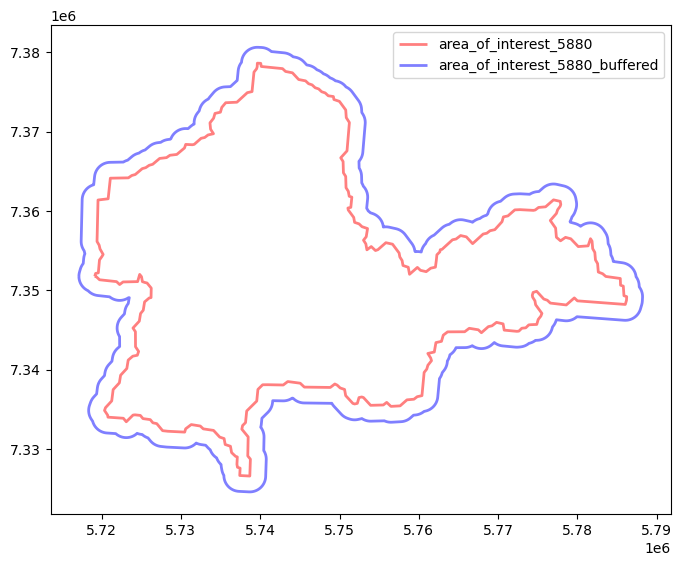

In [ ]:
plot_shapes([
    conf["vectors"]["aoi"]["out_path"],
    conf["vectors"]["aoi"]["buffered_path"]
])

Next, let's do a basic check of what is needed on our rasters.

In [ ]:
for layer_name, rconf in conf["rasters"].items():
    print("Layer Name:", layer_name)
    print_raster_info(rconf["raw_path"])
    print()

Layer Name: lulc
CRS: EPSG:4326
Width, Height: 6156 5442
Bounds: BoundingBox(left=-47.442365774090646, bottom=-24.491398411649392, right=-45.78335710737871, top=-23.024808878795863)
Transform: | 0.00, 0.00,-47.44|
| 0.00,-0.00,-23.02|
| 0.00, 0.00, 1.00|
Number of bands: 1
Data type: ('uint8',)
NoData value: None
Resolution: (0.0002694945852358564, 0.0002694945852358564)

Layer Name: dem
CRS: EPSG:4326
Width, Height: 5972 5280
Bounds: BoundingBox(left=-47.44236111109353, bottom=-24.49152777778899, right=-45.78347222220442, top=-23.024861111122128)
Transform: | 0.00, 0.00,-47.44|
| 0.00,-0.00,-23.02|
| 0.00, 0.00, 1.00|
Number of bands: 1
Data type: ('int16',)
NoData value: -32768.0
Resolution: (0.00027777777777781464, 0.00027777777777781464)

Layer Name: soil_erodibility
CRS: EPSG:4326
Width, Height: 714 632
Bounds: BoundingBox(left=-47.44320211419753, bottom=-24.491924123459725, right=-45.78531982407408, top=-23.0244693321031)
Transform: | 0.00, 0.00,-47.44|
| 0.00,-0.00,-23.02|
| 0.0

In [ ]:
raw_paths = [r["raw_path"] for r in conf["rasters"].values()]
for rp in raw_paths:
    check_raster(
        rp, 
        conf["project_crs"], 
    )

--- Checking raster: mapbiomas-30m-2023-bbox.tif ---
❌ No Nodata set for: mapbiomas-30m-2023-bbox.tif
❌ Projection mismatch for: mapbiomas-30m-2023-bbox.tif (found: EPSG:4326)
--- Checking raster: srtm-v3-1s-2025-dem-bbox.tif ---
✅ Nodata set for: srtm-v3-1s-2025-dem-bbox.tif
❌ Projection mismatch for: srtm-v3-1s-2025-dem-bbox.tif (found: EPSG:4326)
--- Checking raster: K_factor_EPIC_bbox.tif ---
✅ Nodata set for: K_factor_EPIC_bbox.tif
❌ Projection mismatch for: K_factor_EPIC_bbox.tif (found: EPSG:4326)


We can see that the `mapbiomas-30m-2023-bbox.tif` layer is missing a NoData value. We can suggest one and update our config to use a `setnodata` value. 

The demo config looks like this:

```yaml
"lulc":
    raw_path: "lulc/raw/mapbiomas-30m-2023-bbox.tif"
    out_path: "lulc/mapbiomas-30m-2023-5880.tif"
    setnodata: 255
    resampling: "nearest"
```

In [ ]:
suggest_nodata(conf["rasters"]["lulc"]["raw_path"])

255

Moreover, we can see that the rasters are not clipped to the study area:

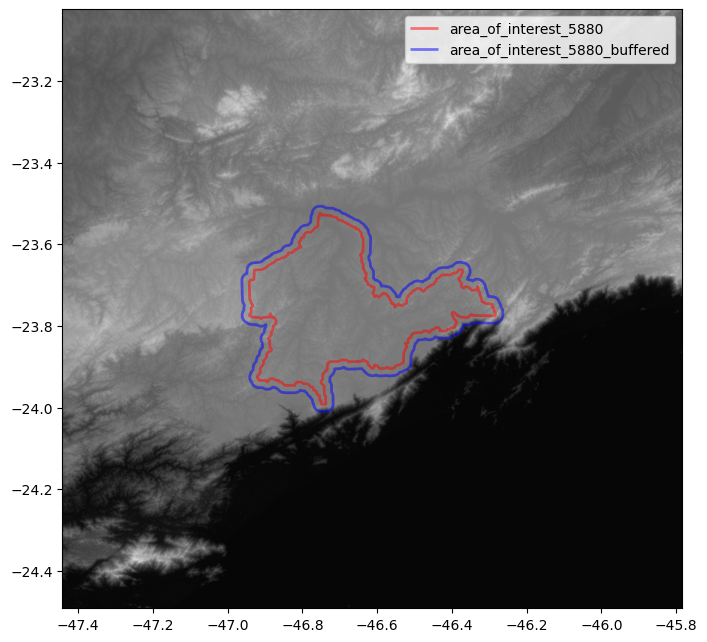

In [ ]:
plot_raster_with_shape(
    conf["rasters"]["dem"]["raw_path"],
    [conf["vectors"]["aoi"]["out_path"], conf["vectors"]["aoi"]["buffered_path"]]
)

Let's create a pipeline.

In [ ]:
aoi_b = conf["vectors"]["aoi"]["buffered_path"]
crs = conf["project_crs"]

for layer, rconf in conf["rasters"].items():
    print(f"[*] Processing {layer}...")
    run_steps(
        start_path=rconf["raw_path"],
        end_path=rconf["out_path"],
        steps=[
            (set_nodata, {"nodata": rconf["setnodata"]}), # will skip if null
            (warp_raster, {"dst_crs": crs, "resampling": str_to_resampling(rconf["resampling"])}),
            (clip_raster_with_shape, {"shapefile_path": aoi_b})
        ]
    )

[*] Processing lulc...
[*] Processing dem...
[*] Processing soil_erodibility...


Let's inspect the layers:

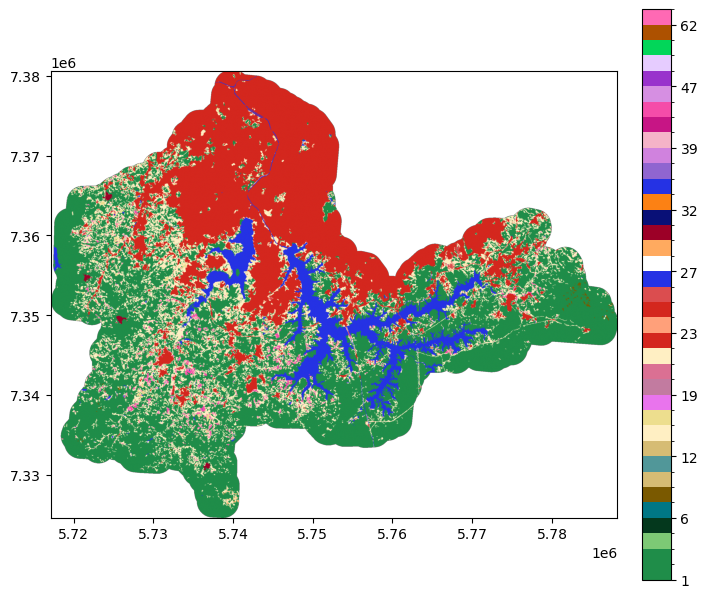

In [ ]:
plot_raster(
    conf["rasters"]["lulc"]["out_path"], 
    clr_path=conf["clr_path"]
)

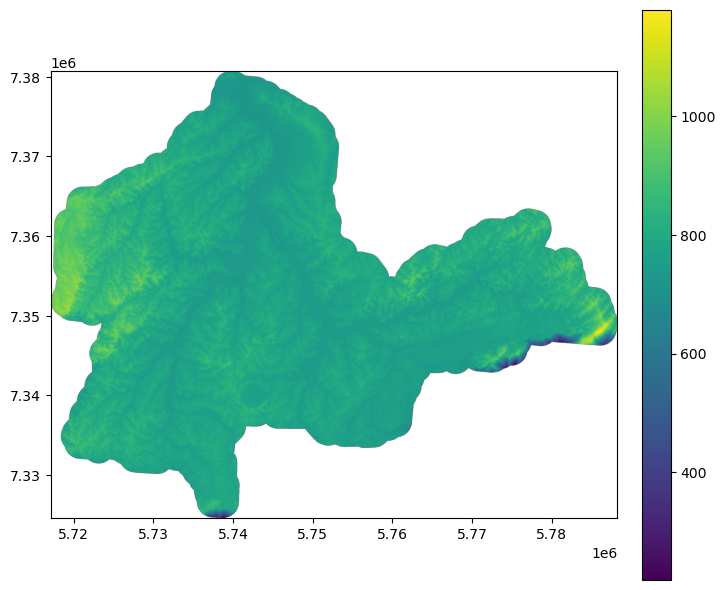

In [ ]:
plot_raster(conf["rasters"]["dem"]["out_path"])

/Users/alice/miniforge3/envs/muir-dev/lib/python3.10/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


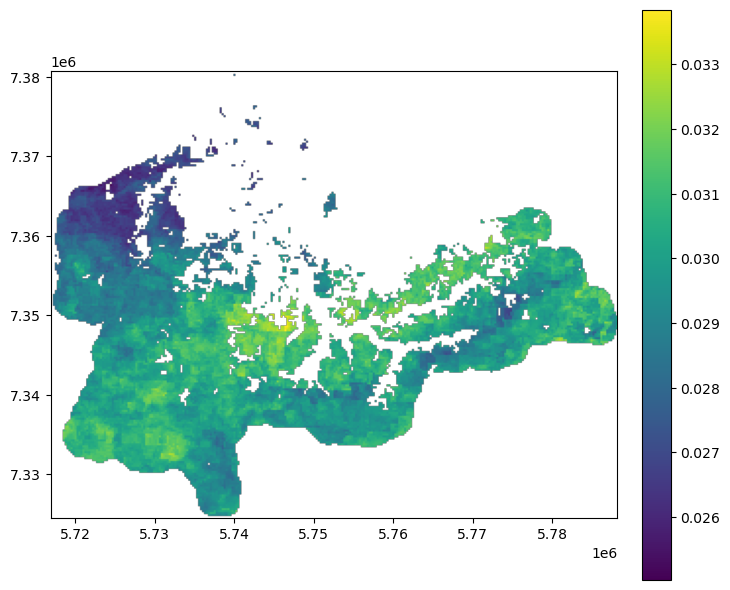

In [ ]:
plot_raster(conf["rasters"]["soil_erodibility"]["out_path"])

Oof! There is missing data in the last one! wW must ensure there are no `Nodata` pixels in the extent we are trying to model. Otherwise, these pixels will be completely blank in the final InVEST outputs.

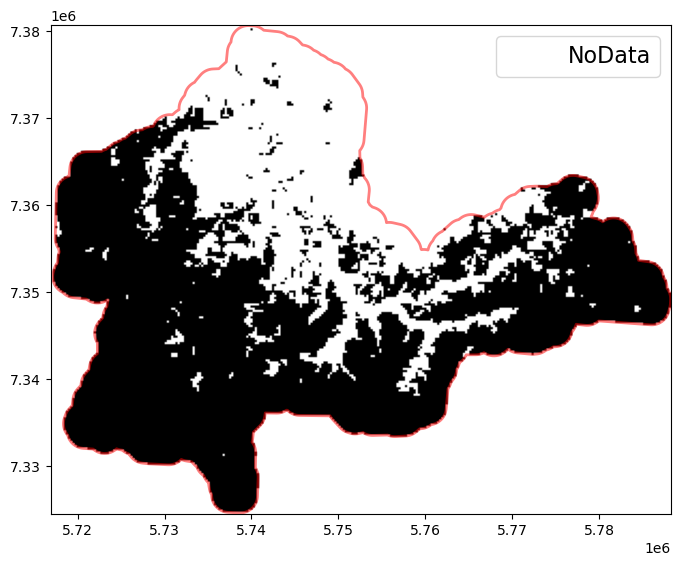

In [ ]:
highlight_nodata(
    conf["rasters"]["soil_erodibility"]["out_path"],
    conf["vectors"]["aoi"]["buffered_path"],
)

Let's do an additional step of processing for our soil layer, ensuring to clip again.

In [ ]:
soil_path = conf["rasters"]["soil_erodibility"]["out_path"]
run_steps(
    start_path=soil_path,
    end_path=soil_path,
    steps=[
        (fill_nodata_with_gdal, {"max_search_dist": 100, "smoothing_iterations":1}),
        (clip_raster_with_shape, {"shapefile_path": aoi_b}),
    ]
)

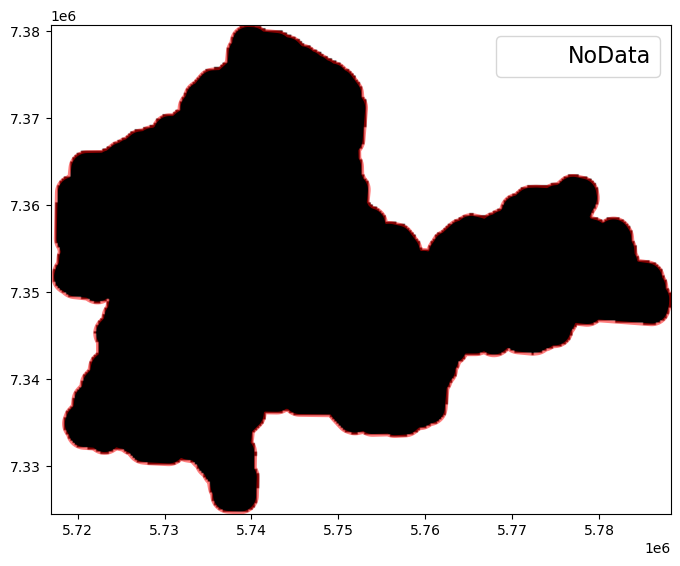

In [ ]:
highlight_nodata(
    conf["rasters"]["soil_erodibility"]["out_path"],
    conf["vectors"]["aoi"]["buffered_path"],
)

In [ ]:
out_paths = [r["out_path"] for r in conf["rasters"].values()]
for op in out_paths:
    check_raster(
        op, 
        conf["project_crs"], 
    )

--- Checking raster: mapbiomas-30m-2023-5880.tif ---
✅ Nodata set for: mapbiomas-30m-2023-5880.tif
✅ Projection OK for: mapbiomas-30m-2023-5880.tif
--- Checking raster: srtm-v3-1s-2025-dem-5880.tif ---
✅ Nodata set for: srtm-v3-1s-2025-dem-5880.tif
✅ Projection OK for: srtm-v3-1s-2025-dem-5880.tif
--- Checking raster: K-factor-EPIC-5880.tif ---
✅ Nodata set for: K-factor-EPIC-5880.tif
✅ Projection OK for: K-factor-EPIC-5880.tif


Let's hop into QGIS and do a final check.

Then, we can transfer the preprocess config into a new config used for running the experiments.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()